In [93]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from scipy import stats
from scipy.stats import chi2_contingency

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly
import plotly.graph_objs as go

init_notebook_mode(connected=True)

Данные взяты с kaggle https://www.kaggle.com/rush4ratio/video-game-sales-with-ratings

В датасете представлены данные о выпущенных играх

****Name**** - имя игры 

****Platform**** - игровая платформа для которой игра была выпущена

****Year_of_Realeas**** - год выпуска игры

****Genre**** - жанр игры

****Publisher**** - компания выпустившая игру

****NA_Sales**** - продажи в Северной Америке

****EU_Sales**** - продажи в Европе

****JP_Sales**** - продажи в Японии

****Other_Sales**** - продажи в других местах

****Global_Sales**** - продажи по всему миру

****Critic_Score**** - оценка игровых критиков

****Critic_Count**** - количество критиков, поставивших оценку

****User_Score**** - оценка игроков

****User_Count**** - количество игроков поставивших оценки

****Developer**** - разработчик игры

****Rating**** - возрастной рейтинг

Данные об оценках критиков и игроков взяты с сайта https://www.metacritic.com/game

In [94]:
df = pd.read_csv('Video_Games_Sales_as_at_22_Dec_2016.csv')
print(df.shape)

(16719, 16)


In [29]:
df.describe()

,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Count
count,16450.000000,16719.000000,16719.000000,16719.000000,16719.000000,16719.000000,8137.000000,8137.000000,7590.000000
mean,2006.487356,0.263330,0.145025,0.077602,0.047332,0.533543,68.967679,26.360821,162.229908
std,5.878995,0.813514,0.503283,0.308818,0.186710,1.547935,13.938165,18.980495,561.282326
min,1980.000000,0.000000,0.000000,0.000000,0.000000,0.010000,13.000000,3.000000,4.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,0.060000,60.000000,12.000000,10.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,0.170000,71.000000,21.000000,24.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,0.470000,79.000000,36.000000,81.000000
max,2020.000000,41.360000,28.960000,10.220000,10.570000,82.530000,98.000000,113.000000,10665.000000


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16719 entries, 0 to 16718
Data columns (total 16 columns):
Name               16717 non-null object
Platform           16719 non-null object
Year_of_Release    16450 non-null float64
Genre              16717 non-null object
Publisher          16665 non-null object
NA_Sales           16719 non-null float64
EU_Sales           16719 non-null float64
JP_Sales           16719 non-null float64
Other_Sales        16719 non-null float64
Global_Sales       16719 non-null float64
Critic_Score       8137 non-null float64
Critic_Count       8137 non-null float64
User_Score         10015 non-null object
User_Count         7590 non-null float64
Developer          10096 non-null object
Rating             9950 non-null object
dtypes: float64(9), object(7)
memory usage: 2.0+ MB


Видно что есть очень много пропусков в оценках игроков и критиков, также ****User_Score**** помечен как object, изменим его на float.

In [95]:
df['User_Score'] = pd.to_numeric(df['User_Score'], errors='coerce')

На мой взгялд не так важно количество критиков и игроков, оценивших игру (плюс эти поля с большим количество пропусков).

Также я считаю, что компания, выпустившая игру (****Publisher****), важнее компании, её разработавшую (****Developer****), т.к. чаще всего компании-разработчики это часть компании которая эту игру выпустила.Возможно я ошибаюсь, и там более запутанные связи, но для простоты понимания, я всё же отброшу ****Developer****, дальше буду говоря "разработчик" иметь ввиду компанию, опубликовавшую это игру.

In [96]:
df = df.drop(['User_Count', 'Critic_Count', 'Developer'], axis=1)

Стоит заметить так же что у нас присутствуют игры "выпущенные" в 2017 и 2020 годах, тогда как датасет собирался в 2016. Скорее все это данные о предзаказах этих игр, которые по моему мнению не имеют интереса.

In [97]:
df = df.drop(df[df['Year_of_Release'] > 2016.0].index)

***Об исследовании:***

Цель исследования будет состоять в том, чтобы посмотреть как выглядит рынок игровой индустрии. 

***1. ***Какие общие черты присущи средним по объему выпущенных игр компаниям. 

***2. ***Поискать особенности среди компаний, игровых жанров, рынков реализации игр.

***3. ***Также посмотреть в каких областях "большие" компании не так распространены, а основную часть рынка занимают "средние".

Попытаюсь позамечать какие-то дополнительные инсайты по ходу дела.

Вначале банально посмотрим на какие-то основные характеристики и основыне зависимости, котоыре первые приходят в голову.

Первое - продажи и количество релизов по годам.

Text(2015,400,'')

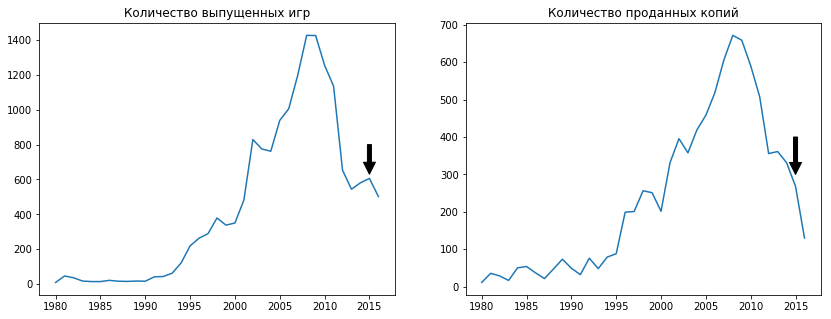

In [34]:
games = df['Year_of_Release'].value_counts().sort_index()
sales = df.groupby(by='Year_of_Release')['Global_Sales'].sum()

fig = plt.figure(figsize= (14,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(games)
ax1.set_title('Количество выпущенных игр')
ax2.plot(sales)
ax2.set_title('Количество проданных копий')

ax1.annotate('', xy=(2015, 630), xytext=(2015, 800),
            arrowprops=dict(facecolor='black'),
            )
ax2.annotate('', xy=(2015, 300), xytext=(2015, 400),
            arrowprops=dict(facecolor='black'),
            )

Как видно - изначально спрос на игры рос вместе с количеством выпускаемых игр, но после 2009 игры стали продаваться меньше, возможно это связано с кризисом и уменьшением покупательской способности. Также можно заметить, то что игровая индустрия делала попытку оживиться в 2015 году, но спрос всё так же падает, что говорит о том что люди скорее всего находят другие способы развлечения. 

Дальше взглянем на то какике результаты показывают топ10 компаний.

Text(0.5,1,'Количество выпущенных игр')

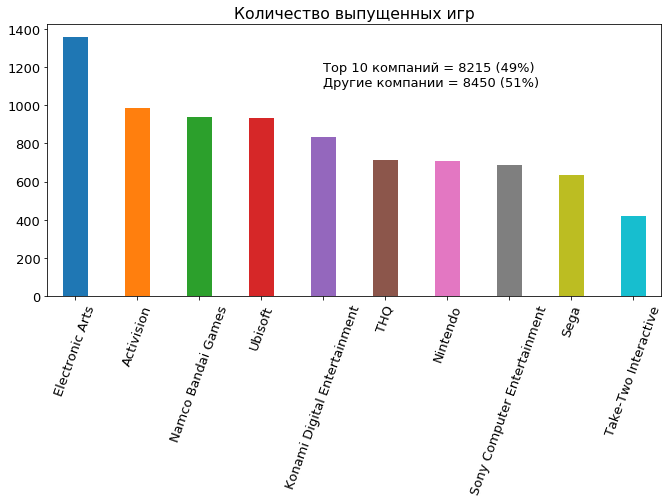

In [36]:
x = df['Publisher'].value_counts()[:10]

plt.rcParams['font.size'] = 13 

fig = plt.figure(figsize=(11,5))

ax = x.plot.bar(rot=70, width=0.4)
ax.annotate('Top 10 компаний = 8215 (' + str(round(8210/16650 * 100)) + "%)" + '\n'
            + 'Другие компании = 8450 (' + str(round(8450/16650 * 100)) + "%)",
            xy=(4,1100))
ax.set_title('Количество выпущенных игр')

Text(0.5,1,'Количество проданных копий')

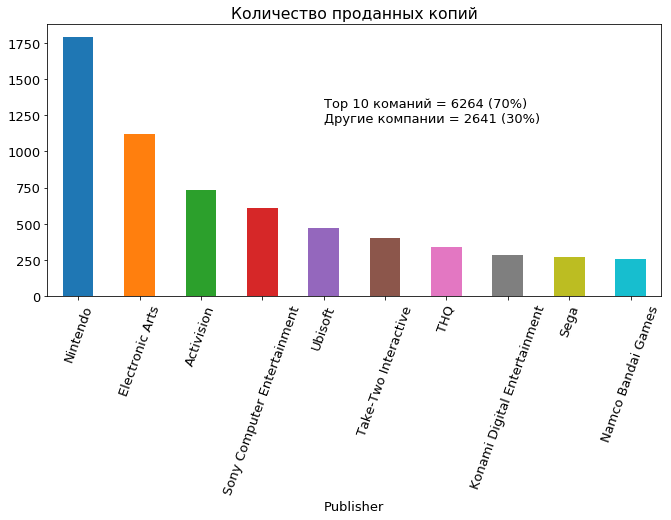

In [38]:
sales = df.groupby(by='Publisher')['Global_Sales'].sum().sort_values(ascending=False)[:10]
fig = plt.figure(figsize=(11,5))
ax = sales.plot(kind='bar', rot=70)
ax.annotate('Top 10 команий = 6264 (70%) \n'
            + 'Другие компании = 2641 (30%)', xy=(4, 1200))
ax.set_title('Количество проданных копий')

Интуитивно понятно что компании с самым большим количеством выпущенных игр имеют больше всех продаж. Но можно заметить, что большинство этих компаний на превом графике примерно выпустили одинаковое количество игр ~ около ****800****, в то время как на втором графике различие в продажах сильно заметно.

Посмотрим как скореллированы признаки

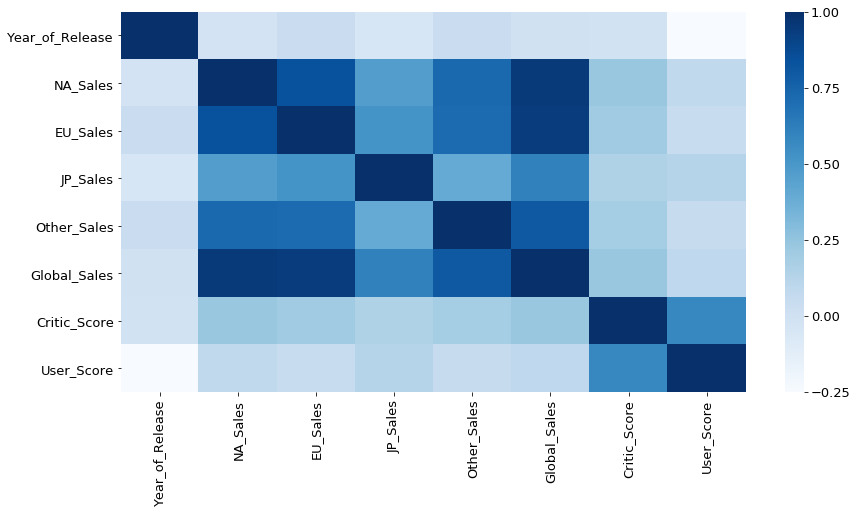

In [39]:
df_corr = df.drop(['Name', 'Platform', 'Genre', 
                   'Publisher', 'Rating'], axis=1)
fig = plt.figure(figsize= (14,7))
sns.heatmap(df_corr.dropna().corr(), 
            xticklabels = df_corr.columns.values,
            yticklabels = df_corr.columns.values, 
            cmap = 'Blues')

Интересное замечание, что оценка критиков и игроков не очень сильно влияет на продажи игры. Плюс видно, что продажи в Японии меньше кореллируют с продажми в остальных частях света, что говорит нам об особенностях Японского рынка.

Также год выпуска игры никак не связан с продажами, поэтому можно предположить, что игровая индустрия это не инертный рынок. Это вытекает также из того, что выше мы видели как резко поднимается и опускается спрос на игры, но при этом компании умеют быстро подстраиваться под количество спроса. И графики продаж и выпускаемых игр почти повторяют друг друга.

Узнаем кто более строг в оценивании игр

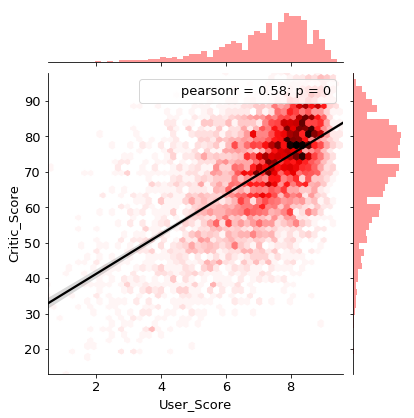

In [43]:
ax = sns.jointplot(x='User_Score', y='Critic_Score', data=df, color='red', kind = 'hex')
sns.regplot(df.User_Score, df.Critic_Score, ax=ax.ax_joint, scatter=False, color='black')

Таким образом критики, как ни странно, снисходительнее к издателям игр и чаще ставят высокие оценки

#### Сейчас перейдём к конкретному рассмотрению.

Посмотрим какие жанры захватили "большие" компании (буду считать для определенности, что это топ20 компаний по объему продаж, средние это следующие 300 компаний), для каких игровых платформ они чаще всего разрабатывают игры, и в каких годах они имели особый успех.

In [6]:
df_top_names = pd.DataFrame(df.groupby(by='Publisher')['Global_Sales'].sum().sort_values(ascending=False)[:20])
df_top = df.loc[df.Publisher.isin(df_top_names.index)]

df_middle_names = pd.DataFrame(df.groupby(by='Publisher')['Global_Sales'].sum().sort_values(ascending=False)[20:320])
df_middle = df.loc[df.Publisher.isin(df_middle_names.index)]

Соотношение по жанрам.

In [7]:
df_top_genre = pd.DataFrame(df_top.groupby(by='Genre')['Global_Sales'].sum().sort_values(ascending=False))
df_middle_genre = pd.DataFrame(df_middle.groupby(by='Genre')['Global_Sales'].sum().sort_values(ascending=False))

df_together = pd.merge(df_top_genre, df_middle_genre, on='Genre')
df_together['Percent'] = df_together.Global_Sales_y / df_together.Global_Sales_x

In [8]:
trace1 = go.Bar(
    x=df_top_genre.index,
    y=df_top_genre.Global_Sales,
    name='Global Sales by top20'
)

trace2 = go.Bar(
    x=df_middle_genre.index,
    y=df_middle_genre.Global_Sales,
    name='Global Sales by middle companies')

trace_table = go.Table(
    header=dict(values=['Genre', 'Percent']),
    cells=dict(values=[df_together.index, df_together.Percent],
               height=40),
    domain=dict(x=[0.5, 1],
                y=[0.5, 1]),
    name='Соотношение продаж')

data = [trace1, trace2, trace_table]
layout = {'title': 'Соотношение по жанрам'}

fig = go.Figure(data=data, layout=layout)
iplot(fig, show_link=False)

В таблице приведены отношения объемов продаж в зависимости от жанра.

Отсюда сразу можно увидеть как жанры распределены по популярности. Следующее замечание: что закономерно - большие компании максимально заняли самые популярные жанры. Но не всё так ужасно, средние комании всё ещё занимают важное место в таких жанрах как: ****Role-Playing****, ****Simulation****, ****Puzzle****, ****Adventure**** и ****Strategy****.

Плюсом средние компании "обжились" примерно одинаково во всех жанрах, не выделяется каких-то особенных, сильно отличающихся по продажам от других.

Аналогично посмотрим на связь с игровыми платформами

In [75]:
df_top_platform = pd.DataFrame(df_top.groupby(by='Platform')['Global_Sales'].sum().sort_values(ascending=False))
df_middle_platform = pd.DataFrame(df_middle.groupby(by='Platform')['Global_Sales'].sum().sort_values(ascending=False))

df_together = pd.merge(df_top_platform, df_middle_platform, on='Platform')
df_together['Percent'] = df_together.Global_Sales_y / df_together.Global_Sales_x

In [77]:
trace1 = go.Bar(
    x=df_top_platform.index,
    y=df_top_platform.Global_Sales,
    name='Global Sales by top20'
)

trace2 = go.Bar(
    x=df_middle_platform.index,
    y=df_middle_platform.Global_Sales,
    name='Global Sales by middle companies')

trace_table = go.Table(
    header=dict(values=['Platform', 'Percent']),
    cells=dict(values=[df_together.index, df_together.Percent],
               height=40),
    domain=dict(x=[0.5, 1],
                y=[0.5, 1]))

data = [trace1, trace2, trace_table]
layout = {'title': 'Соотношение по платформам'}

fig = go.Figure(data=data, layout=layout)
iplot(fig, show_link=False)

Аналогично здесь самые популярные платформы практически польностью заняты большими компаниями, интересное замечание, что на платформе ****PS**** процент средних компаний больше всего, но это уже устаревшая платформа на наше время, т.е. возможно средние компании имели большой вес в прошлом, когда ещё не была так сильно развита игровая индустрия.

Посмотрим как изменялись продажи средних и больших компаний со временем.

In [98]:
df_middle_time = pd.DataFrame(df_middle.groupby('Year_of_Release') \
                              ['Global_Sales'].sum().sort_index(ascending=False))
df_top_time = pd.DataFrame(df_top.groupby('Year_of_Release') \
                           ['Global_Sales'].sum().sort_index(ascending=False))

In [99]:
trace1 = go.Scatter(
    x=df_middle_time.index,
    y=df_middle_time.Global_Sales,
    name='Global Sales by middle companies'
)

trace2 = go.Scatter(
    x=df_top_time.index,
    y=df_top_time.Global_Sales,
    name='Global Sales by top20 companies'
)

layout = {'title': 'Global Sales'}
data = [trace1, trace2]

fig = go.Figure(data=data, layout=layout)
iplot(fig, show_link=False)

* Нынешние большие компании это в основном те, которые на рынке с самого его зарождения, это видно по тому как в 80х годах синяя линия около нуля, в то время как желтая явно выше.

* Разница начала резко расти в 90ые годы, сложно сказать с чем это могло быть связано, возможно люди открыли для себя новый абсолютно неизведанный способ развлечения. И большие компании оперативно прореагировали на растущий спрос (выше я писал о том что игровой рынок очень гибкий).

* Несмотря на огромный скачок и резкое падение продаж больших компаний - средние компании имеют постоянный спрос, который не сильно менялся за последние годы. Может быть средние компании поняли свою аудиторию и максимально нацелены на неё.

Возможно самое интересное замечание:

* Тут же видно, что в 1995-2000 годах был один из пиков продаж средними компаниями, как раз в 1995 году вышла платформа ****PS****, а в 2000 ****PS2****. Это подтверждается данными выше - платформа ****PS**** самая "любимая" у средних компаний. На ум сразу приходит идея о том, что средние компании не смогли вовремя перестроиться с этой платформы на новую платформу ****PS2**** - что сделали большие компании. Это опять же подтвеждается предыдущим графиком - платформа ****PS2**** очень популярна у больших разработчиков. Есть шанс что именно это позволило так сильно оторваться большим компаниям.

Взглянем на то, кому отдают большее предпочтение люди в разных частях света.

In [83]:
df_middle_jp = df_middle.JP_Sales.sum()
df_top_jp = df_top.JP_Sales.sum()

df_top_na = df_top.NA_Sales.sum()
df_middle_na = df_middle.NA_Sales.sum()

df_top_eu = df_top.EU_Sales.sum()
df_middle_eu = df_middle.EU_Sales.sum()

df_middle_oth = df_middle.Other_Sales.sum()
df_top_oth = df_top.Other_Sales.sum()

In [84]:
trace1 = go.Pie(labels=['Top20', 'Middle comp.'], 
               values=[df_top_jp, df_middle_jp],
               domain=dict(x=[0.45, 1],
                           y=[0.45, 1]),
               name='Продажи в Японии'
              )
trace2 = go.Pie(labels=['Top20', 'Middle comp.'], 
               values=[df_top_na, df_middle_na],
               domain=dict(x=[0, 0.55],
                           y=[0.45, 1]),
               name='Продажи в Северной Америке'
              )
trace3 = go.Pie(labels=['Top20', 'Middle comp.'], 
               values=[df_top_eu, df_middle_eu],
               domain=dict(x=[0.22, 0.77],
                           y=[0, 0.55]),
               name='Продажи в Европе'
              )
trace4 = go.Pie(labels=['Top20', 'Middle comp.'], 
               values=[df_top_oth, df_middle_oth],
               domain=dict(x=[0.8, 1],
                           y=[0, 0.3]),
               name='Продажи в других местах'
              )


data = [trace1, trace2, trace3, trace4]

fig = go.Figure(data=data, layout=layout)
iplot(fig)

Япония больше других предпочитает менее известных разработчиков, сложно усмотреть какую-то зависимость, возможно среди средних компаний присутствует немало из Японии.

Резюмируя промежуточные данные:

1. В целом топ20 компании заняли все части игровой индустрии, в особенности самые распространеённые (Action, Sports, Shooter), но несмотря на это оставшиеся компании всё ещё могут побороться с такими же небольшими компаниями за свою аудиторию в следующих жанрах: ****Role-Playing****, ****Simulation****, ****Puzzle****, ****Adventure**** и ****Strategy****. 

2. Также средние разработчики неплохо чувствовали себя в разработке под платформу ***PS***, но не открылись новой игровой платформе, из-за чего скорее всего и проиграли большим компаниям.

3. Имеет смысл посомтреть в сторону игрового рынка Японии, в силу того что там меньше продаж имеют крупные компании, можно попытаться поконкурировать с равными разработчиками.

4. Игровой рынок уже поделён между старыми крупными компаниями, но заметное уменьшение интереса к их продуктам может дать возможности для роста небольшим компаниям со свежими идеями, которые смогут привнести чего-то нового в эту сферу.

Дальше попытаемся поискать какие-то отдельные особенности.

Интуитивно кажется, что самые успешные компании это те, которые выпустили немного игр, но сделали много продаж.
Посмотрим, на то как выглядят такие компании, может быть существует какой-то общий секрет их успеха.

In [46]:
sales = pd.DataFrame(df.groupby(by='Publisher')['Global_Sales'].sum().sort_values(ascending=False))

relese = pd.DataFrame(data=df['Publisher'].value_counts())
relese = relese.rename(columns={'Publisher': 'Games'})
relese['Publisher'] = relese.index

df_companies = pd.merge(sales, relese, on='Publisher')
df_companies['sale_per_game'] = df_companies.Global_Sales / df_companies.Games
df_companies = df_companies.sort_values(by='sale_per_game', ascending=False)

In [49]:
trace = go.Bar(
    x=df_companies['Publisher'][:15],
    y=df_companies['sale_per_game'][:15],
    marker=dict(
        color=df_companies['sale_per_game'][:15],
        colorscale = 'Reds')
)

trace_table = go.Table(
    header=dict(values=df_companies.columns,
                fill = dict(color='#F0C2C2')),
    cells=dict(values=[df_companies.Publisher[:15], df_companies.Global_Sales[:15],
                       df_companies['Games'][:15], df_companies.sale_per_game[:15]],
               fill = dict(color='#F8E2E2'),
               height=40),
    domain=dict(x=[0, 1],
                y=[0, 1]))

data = [trace]
layout = go.Layout(
    title='Top компании по количеству продаж на одну игру'
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

data = [trace_table]
fig = go.Figure(data=data)
iplot(fig)

Сразу можно заметить интересную вещь - большинство этих компаний имеют 1-4 выпущенных игры за всё время, рассмотрим их более подробно.

In [9]:
comp = (df.Publisher == 'Palcom') | (df.Publisher == 'Red Orb') | \
       (df.Publisher == 'Arena Entertaiment') | (df.Publisher == 'UEP Systems') | \
       (df.Publisher == 'RedOctane') | (df.Publisher == 'Valve') | \
       (df.Publisher == 'Hello Games') | (df.Publisher == 'Sony Computer Entertaiment') | \
       (df.Publisher == 'Westwood Studios') | (df.Publisher == 'Imagic') | \
       (df.Publisher == 'Black Label Games') | (df.Publisher == 'Maxis')
# не включил компании с большим количесвтом релизов
df[comp].head(5)

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,User_Score,Rating
196,Guitar Hero II,PS2,2006.0,Misc,RedOctane,3.81,0.63,0.00,0.68,5.12,92.0,8.5,T
279,Teenage Mutant Ninja Turtles,NES,1989.0,Action,Palcom,3.38,0.44,0.31,0.04,4.17,NaN,NaN,NaN
521,Myst,PC,1994.0,Adventure,Red Orb,0.02,2.79,0.00,0.00,2.81,NaN,NaN,NaN
637,Riven: The Sequel to Myst,PC,1997.0,Adventure,Red Orb,1.52,0.82,0.00,0.10,2.43,83.0,NaN,E
660,Guitar Hero,PS2,2005.0,Misc,RedOctane,1.67,0.61,0.03,0.07,2.38,91.0,8.7,T


In [16]:
df[comp].Year_of_Release.median()

1997.0

Ещё одно странное замечание - приведенные выше компании выпустили 1-4 игры, которые оказали очень успешными, но тем не менее не продолжили дальше свою работу. + большинство выпущенных ими игр приходится на конец 90х - начало бурного роста больших компаний. Почему в таком случае успешные компании выпустив буквально пару игр прекращяли свою деятельность? Если посмотреть истории этих компаний то всё становится очень логично:
* Эти компании были дочерними, чтобы избежать каких-то законодательных ограничений, касательно продаж в разных частях света (например ****Palcom****).

* Данные фирмы были куплены крупными издателями (****RedOctane****).

* Это были дочерние компании больших разработчиков, которые использовались для реализации нетипичного данной компании  продукта (например компания была занята в образовательной сфере, но решила начать так же разрабатывать игры) (****RedOrb****).

* Комания выпустила парочку успешных игр на PS, но несколько следующих, выпущенных на PS2 были сильно раскритикованны пользователями (****UEP Systems****). (Что подтвеждает мою идею о том, что средние компании не выдержали перемен)

К сожалению никакого волшебного секрета здесь не оказалось.

#### Сделаем несколько статистических гипотез.

Начнём с проверки того, является ли приставка ****X360**** такой же популярной для разработчиков в своё время как ****PS**** в своё.

1. Проверим принадлежат ли обе выборки нормальному распределению, для проверки используем критерий *Шапиро-Уилко*.

In [20]:
df_ps = df[df.Platform == 'PS']['Year_of_Release'].value_counts().sort_index(ascending=False)
df_ps = np.array(df_ps)
stats.shapiro(df_ps)

(0.9260306358337402, 0.41000327467918396)

In [21]:
df_x360 = df[df.Platform == 'X360']['Year_of_Release'].value_counts().sort_index(ascending=False)
df_x360 = np.array(df_x360)
stats.shapiro(df_x360)

(0.955607533454895, 0.7197787761688232)

Обе выборки принадлежат нормальному распределению. Тогда т.к мы сравниваем две выборки из нормальных распределений, то мы можем применить *критерий Стьюдента*.

При этом нулевая гипотеза:

$H_0 :$ в своё время для X360 выпускали игры так же часто как и для PS в своё.

Уровень значимости возьмём 5%

Также нарисуем графики.

Text(0.5,1,'Количество выпущенных игр для PS')

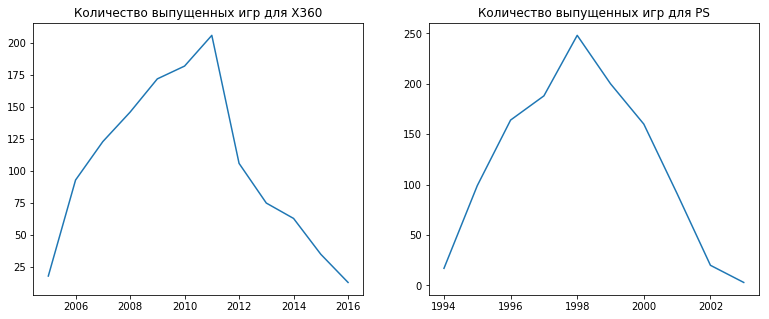

In [32]:
fig = plt.figure(figsize=(13,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

df_x360_plot = pd.DataFrame(df[df.Platform == 'X360']['Year_of_Release'].value_counts().sort_index(ascending=False))
ax1.plot(df_x360_plot)
ax1.set_title('Количество выпущенных игр для X360')

df_ps_plot = pd.DataFrame(df[df.Platform == 'PS']['Year_of_Release'].value_counts().sort_index(ascending=False))
ax2.plot(df_ps_plot)
ax2.set_title('Количество выпущенных игр для PS')

In [33]:
stats.ttest_ind(df_ps, df_x360)

Ttest_indResult(statistic=0.507909485369489, pvalue=0.6170727656473012)

Нулевая гипотеза подтверждается при уровне значимости больше 5%, т.е. в нашем случае выборки взяты из одного распределения, и гипотеза верна.

(Стоит заметить, что я не просто так сравнивал эти платформы, ****Xbox**** и ****PS**** являются конкурентами, и их сравнение имеет некоторую оссмысленность, в отличие от того если бы я сравнивал две платформы каждая из которых абсолютно отличается от другой, в моём случае эти плтаформы имеют одинаковою концепцию)

Здесь видно неявное отставание: в то время как разработчики ещё в 90х уделяли серии платформ ****PS**** много внимания, то для платформ из серии ****Xbox**** они начали разрабатывать игры в большом количестве гораздо позже. Грубо говоря разработчики только-только стали серьёзно воспринимать платформу ****Xbox****.

(Но всё-таки сравнивать игровые платформы, каждая из которых была популярна в разное время это немного нелогично, к сожалению другие представители имеют ненормальное распределение.)

Сейчас посомтрим на применение непараметрического критерия хи-квадрат. 

Для этого рассмотрим как оценивали игры компании ****Electronic Arts**** критики и игроки. Интуитивно кажется, что вобще эти оценки не должны сильно отичаться, т.к. иначе кто-то из них нечестен, либо слишком предвзят.

In [38]:
df_ea = df[df.Publisher == 'Electronic Arts']

df['User_Score'] = pd.to_numeric(df['User_Score'], errors='coerce')

more80_critic = len(df_ea[df.Critic_Score >= 80])
less80_critic = len(df_ea[df.Critic_Score < 80])

more8_user = len(df_ea[df.User_Score >= 8.0])
less8_user = len(df_ea[df.User_Score < 8.0])

total = more80_critic + less80_critic + more8_user + less8_user

df_ea_matr = pd.DataFrame({'больше 8.0': [more80_critic, more8_user, more80_critic+more8_user],
                           'меньше 8.0': [less80_critic, less8_user, less80_critic+less8_user],
                           'всего': [more80_critic+less80_critic, more8_user+less8_user, total]},
                         index=['Критики', 'Игроки', 'Вместе'])
df_ea_matr

,больше 8.0,меньше 8.0,всего
Критики,417,612,1029
Игроки,321,705,1026
Вместе,738,1317,2055


В качестве номинальной шкалы возьмём: критик/игрок поставил оценку выше 8.0 и ниже соответсвтенно. Наблюдений для использования критерия достаточно, и они не являются связанными. В таком случае можно применить критерий хи-квадрат.

Нулевая гипотеза звучит так:

$H_0:$ критики и игроки одинаково часто ставят хорошие и плохие оценки играм компании ****Electronic Arts****.

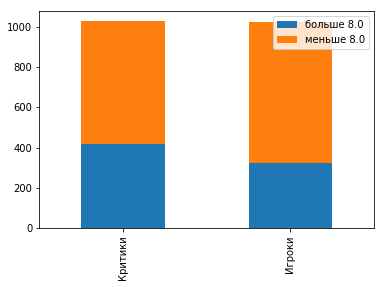

In [41]:
df_ea_matr.iloc[:2, :2].plot.bar(stacked=True)

In [40]:
chi2_contingency(df_ea_matr.iloc[:2,:2])

(18.651384888052966,
 1.5693323987536103e-05,
 1,
 array([[369.53868613, 659.46131387],
        [368.46131387, 657.53868613]]))

Значение p сильно меньше 0.05, что гооврит о том, что различие в расстановке оценок критиками существенно отличается от расстановки оценок игроками. 

* Возможно игроки и критики обращают внимание на разные детали. 

* Либо кто-то из этих групп более пердвзят. 

* Или же можно сделать достаточно громокое предположение о том, что ****Electronic Arts**** покупает более высокие оценки критиков для рекламы некоторых игр. 

Ненмого погуглив становится ясно, что эта причина кроется в первом предположении. ****Electronic Arts**** имеют очень нелюбимую игроками бизнес модель, которая включает в себя большое число микроплатежей внутри игры, без которых игра не такая полная. Скорее всего критиков это не касается, а вот игроки это ощущают в полной мере, выражая свой негатив в заниженных оценках.

Оценим игры какой компании игроки больше любят ****Activision**** или ****Sony Computer Entertainment****, в качестве оценки будем использовать оценки игроков.

Буду использовать критерий Манна-Уитни, этот критерий не имеет особых условий, он подойдет как и для очень маленьких выборок, так и тем более для больших как в моём случае. Заметим так же что обе этих компании выпустили достаточно много игр (985 - ****Acrivision****, 687 - ****Sony Computer Entertainment****)

Нулевая гипотеза:

$H_0:$ играм, выпущенным ****Activision**** и ****Sony Computer Entertainment**** ставят похожие оценки.

In [46]:
df_activision = pd.DataFrame(df[df.Publisher == 'Activision']
                        ['User_Score'].value_counts().sort_index(ascending=False))
df_sony = pd.DataFrame(df[df.Publisher == 'Sony Computer Entertainment']
                       ['User_Score'].value_counts().sort_index(ascending=False))

trace1 = go.Scatter(
    x=df_activision.index,
    y=df_activision.User_Score,
    name='Scores of Activision'
)

trace2 = go.Scatter(
    x=df_sony.index,
    y=df_sony.User_Score,
    name='Scores of Sony'
)

layout = go.Layout(
    width=800,
    height=400,
    title='Scores of companies')
data = [trace1, trace2]

fig = go.Figure(data=data, layout=layout)
iplot(fig, show_link=False)

In [47]:
df_activision = np.array(df[df.Publisher == 'Activision']
                           ['User_Score'].value_counts().sort_index(ascending=False))
df_sony = np.array(df[df.Publisher == 'Sony Computer Entertainment']
                     ['User_Score'].value_counts().sort_index(ascending=False))

stats.mannwhitneyu(df_activision, df_sony)

MannwhitneyuResult(statistic=1513.5, pvalue=0.02666065432172212)

Из p-значения критерия видно, что нулевую гипотезу стоит отвергнуть. А на графике можно заметить, что ****Sony Computer Entertainment**** игроки очень редко ставят низкие оценки по сравнению с ****Activision****.

Вывод: скорее всего пользователям больше нравятся игры компании ****Sony Computer Entertainment****.

#### Предскажем временной ряд

В качестве предсказания временного ряда расчитаем популярность среди разработчиков игр по отношению к серии платформ ****Play Station**** на 4 года. 

Я объеденил 4 приставки исходя из предположения что они являются продолжением друг друга. Со временем игровые компании делают игры всё сложнее, которые требуют больше мощностей. Для этого производитель выпускает, новую приставку, которая продолжает путь предыдущей, но является на порядко продвинутее в плане железа.

In [54]:
df_ps_history = df[(df.Platform == 'PS') | (df.Platform == 'PS2') | \
                   (df.Platform == 'PS3') | (df.Platform == 'PS4')] \
                  ['Year_of_Release'].value_counts().sort_index()

trace1 = go.Scatter(
    x=df_ps_history.index,
    y=df_ps_history
)

layout = go.Layout(
    width=800,
    height=400,
    title='Популярность PlayStation')
data = [trace1]

fig = go.Figure(data=data, layout=layout)
iplot(fig, show_link=False)

Проверим ряд на стационарность.

In [58]:
df_ps_history = pd.DataFrame(df_ps_history)

import statsmodels.api as sm

stat_test = sm.tsa.adfuller(df_ps_history.Year_of_Release)
print ('adf: ', stat_test[0] )
print ('p-value: ', stat_test[1])
print('Critical values: ', stat_test[4])
if stat_test[0]> stat_test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -3.4413164302135484
p-value:  0.009628491378581709
Critical values:  {'1%': -3.769732625845229, '5%': -3.005425537190083, '10%': -2.6425009917355373}
единичных корней нет, ряд стационарен


Несмотря на стационраность, я один раз продифференцировал ряд, т.к. иначе на графике частичной автокорреляции появляется один чрезмерно сильно выделяющийся лаг.

In [62]:
train_ps_history = df_ps_history.Year_of_Release.diff(periods=1).dropna()

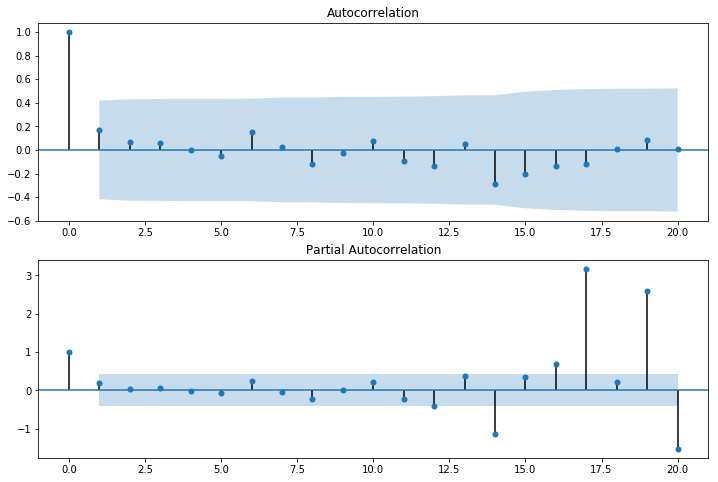

In [63]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train_ps_history.values.squeeze(), lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train_ps_history, lags=20, ax=ax2)

In [78]:
s = 5
# сезонность не силььна видна,
# но она примерно совпадает с периодом выпуска игровых консолей,
# и ненмого выделяется на графике
d = 0 
# немного остранно получается, что я продифференцировал один раз,
# чтобы график автокорреляции выглядел нормально,
# но с d = 0 предсказания выглядядят поприятнее.
D = 0 # не проводил сезонного дифференцирования 

p = 1 # только первый лаг отличен от 0 (рассматривая первые 10)
P = 1 # только 20й лаг сильно отличается

q = 1 # только один лаг сильно отличается от 0
Q = 0 # иначе не работает

In [79]:
best_model=sm.tsa.statespace.SARIMAX(df_ps_history.Year_of_Release.squeeze(), order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit()

In [91]:
forecast = best_model.predict(start = df_ps_history.shape[0], end = df_ps_history.shape[0]+3)
forecast.index = range(2016, 2020)
forecast

2016    204.782514
2017    199.205225
2018    187.032482
2019    177.057350
dtype: float64

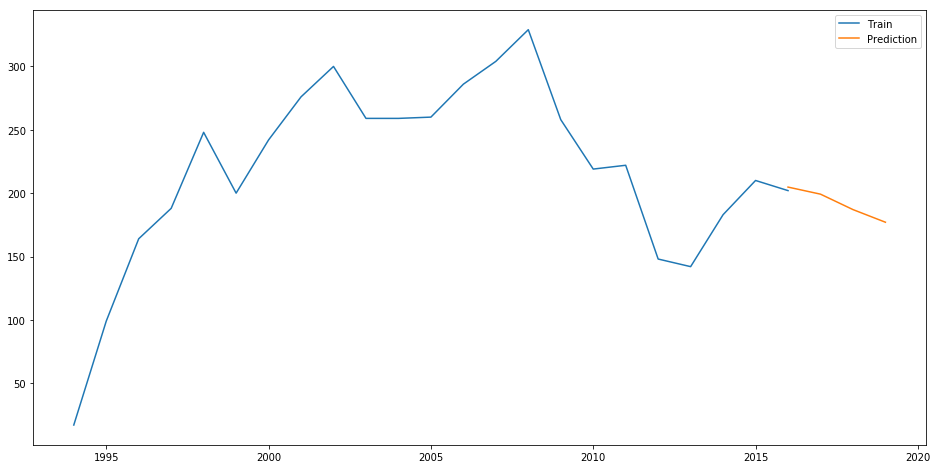

In [90]:
plt.figure(figsize=(16,8))
plt.plot(df_ps_history.Year_of_Release.squeeze(), label='Train')
plt.plot(forecast, label='Prediction')
plt.legend()
plt.show()

Резюмируя проведённое мини-исследование можно сделать несколько выводов и замечаний касательно игровой идустрии.

* Игровая индустрия это очень большой рынок, на котором крепко обосновались крупные компании, но не смотря на это можно заметить, что внимание к релизам больших компаний сильно уменьшилось. Возможно это послужит небольшим преимуществом средним компаниям, которые смогут заинтересовать игроков чем-то особенным, чем не смогли большие.

* Немного было рассмотрено развитие компаний, переломными моментами которого является выпуск платформы ****PS****, что дало огромное внимание к молодым разработчикам и последующий выпуск платформы  ****PS2**** - оставивший всех разработчиков, котоыре не смогли перестроиться, далеко позади.

* Были проверены несколько гипотез, исходя из которой условно можно скзать, вторая серия платформы ****XBox**** привлекла едва столько же внимания у разработчиков, сколько первая платформа ****PlayStation****.

* Также замечено, что игроки не очень любят компанию ****Electronic Arts****, на что ,немного погуглив, нашлись веские причины в виде вездесущих микроплатежей, может этой компании стоит задуматься над сменой бизнес-модели. Если конечно они заботятся о мнении игрков, т.к. игровая сфера это тот же бизнес, а в бизнесе как бы это грубо не было, самое важное это условно прибыль, и возможно текущая бизнес-модель этому условию удовлетворяет более чем.

* При проверке последней незамысловатой гипотезы было обнаружено, что компания ****Sony Computer Entertainment**** больше импонирует нежели ****Activision****. Видимо менеджмент первой компании лучше понимает эту индустрию, это может быть косвенной положительной оценкой этой компании с точки зрения например инвестиций.

* В конце был предсказан временной ряд для серий игровых приставок ****PS**** и видно, что разработчики будут не так активны в ближайшие года, это хорошо состыковывается с вцелом понижающимся спросом в игровой индустрии.